# Scalar Acoustic Wave propagation in a composite 2D field
## Libraries import

In [1]:
import numpy as np
from devito import *
import matplotlib.pyplot as plt
from PyAWD.GenerateVideo import generate_video
from PyAWD.utils import *
from PyAWD.Marmousi import *

## Parameters:
- $nx$ the number of points in the meshgrid side
- $dt$ the interval to compute the steps in the simulation
- $seconds$ the number of seconds of the simulation

In [2]:
nx = 64
ddt = 0.03
dt = ddt*1/24
seconds = 30
nt = int(seconds/dt)
nb_images = int(ddt*nt)

grid = Grid(shape=(nx, nx), extent=(1., 1.))

## Initial condition
We start from a gaussian distribution centered in the field. $c$ is the wave propagation coefficient. Since it is variable across the field, it is represented as a function $c(x, y)$.

In [3]:
u = TimeFunction(name='u', grid=grid, space_order=2, save=nt, time_order=2)
c = Function(name='c', grid=grid)

c.data[:] = Marmousi(nx).get_data()

In [4]:
u.data[:] = get_ricker_wavelet(nx, x0=10, y0=10)

In [5]:
cmap = get_black_cmap()

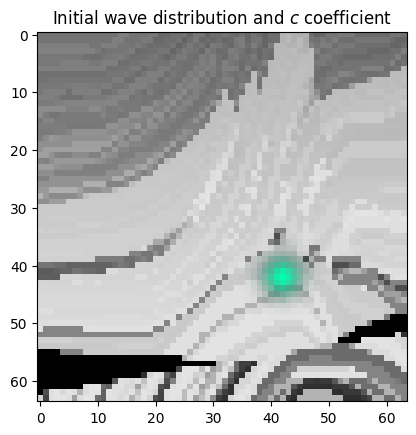

In [6]:
plt.imshow(c.data, vmin=np.min(c.data), vmax=np.max(c.data), cmap="gray", alpha=1)
plt.imshow(u.data[0], vmin=-np.max(np.abs(u.data)), vmax=np.max(np.abs(u.data)), cmap=cmap)
plt.title("Initial wave distribution and "+r"$c$ coefficient")
plt.show()

## Equation
The PDE we want to solve is 
$$\frac{d^2u}{dt^2} = c^2 (\frac{d^2u}{dx^2}+\frac{d^2u}{dy^2})$$

In [7]:
eq = Eq(u.dt2, (c**2)*(u.dx2+u.dy2))
stencil = solve(eq, u.forward)

Which yields the following solution for $u(x, y, t+dt)$:

In [8]:
stencil

dt**2*((Derivative(u(time, x, y), (x, 2)) + Derivative(u(time, x, y), (y, 2)))*c(x, y)**2 - (-2.0*u(time, x, y)/dt**2 + u(time - dt, x, y)/dt**2))

We build an operator that binds $u(x, y, t+dt)$ with this solution:

In [9]:
op = Operator(Eq(u.forward, stencil), opt='noop')

We apply the numerical solver:

In [10]:
op.apply(dt=dt)

Operator `Kernel` ran in 0.16 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.15345000000007725, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [11]:
u.data.shape

(24000, 64, 64)

## Solutions
We plot the evolution through time for the initial condition:

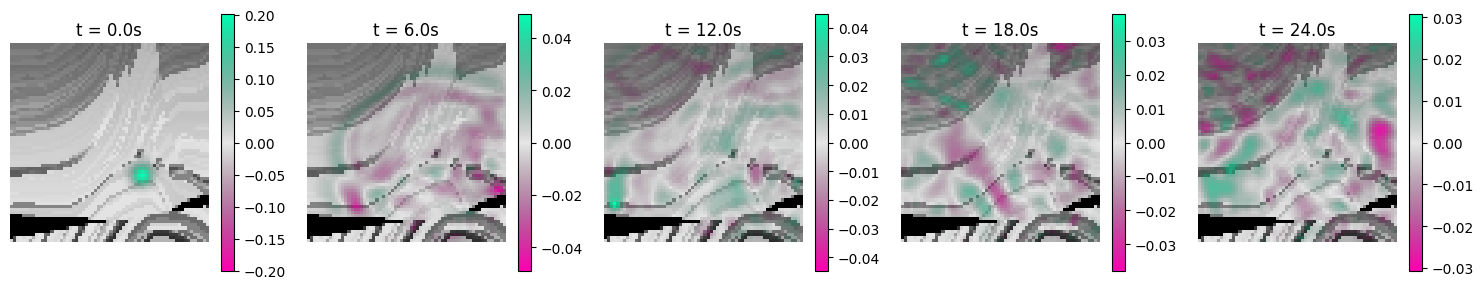

In [12]:
num_examples = 5
fig, ax = plt.subplots(1, num_examples, figsize=(15, 3))
for i in range(num_examples):
    ax[i].imshow(c.data, vmin=np.min(c.data), vmax=np.max(c.data), cmap="gray")
    x = ax[i].imshow(u.data[i*(u.data.shape[0]//num_examples)], 
                     vmin=-np.max(np.abs(u.data[i*(u.data.shape[0]//num_examples):])), 
                     vmax=np.max(np.abs(u.data[i*(u.data.shape[0]//num_examples):])), 
                     cmap=cmap)
    ax[i].set_title("t = " + str(i*(u.data.shape[0]//num_examples)*dt) + "s")
    ax[i].axis("off")
    fig.colorbar(x)
plt.tight_layout()
plt.show()

This will serve as the basis for the dataset generation.